In [ ]:
import sys
import os
if os.getcwd().endswith('notebooks'):
    os.chdir("..")
print(os.getcwd())

## Imports 

In [ ]:
import pandas as pd
import numpy as np
import datetime
import itertools
from math import sqrt
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter
from prophet import Prophet
from prophet.diagnostics import performance_metrics, cross_validation
from prophet.plot import plot_cross_validation_metric
from sklearn.metrics import mean_absolute_error, mean_squared_error
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")

# Data 

## Import the data

In [95]:
df = pd.read_csv(os.path.join('data', 'Canada_Retail_Sales_per_Yr.csv'))
df.head(3)

,period,retail_trade,e_shopping,retail_e_commerce
0,2016-01-01,37415147,679612,877354
1,2016-02-01,36815980,616598,789553
2,2016-03-01,42763737,681191,865677


## Clean and Prepare the data

In [96]:
column_to_use = 'e_shopping' # do we want to observe the "retail_trade", "e_shopping" or "retail_e_commerce"
#++++++++++++++++++++++++++++++++++++++
df = df[['period', column_to_use]]
# Rename the columns since the prophet library insists on 'ds' and 'y' as column names
df.rename({'period': 'ds', column_to_use: 'y'}, axis = 1, inplace = True) 
# Convert Period column as date format
df["ds"] = pd.to_datetime(df["ds"], format='%Y-%m-%d').dt.date
df.head(3)

,ds,y
0,2016-01-01,679612
1,2016-02-01,616598
2,2016-03-01,681191


## Plot the data 

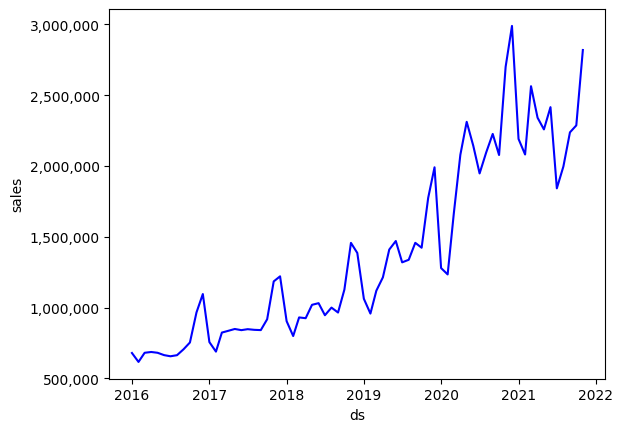

In [81]:
fig, ax = plt.subplots()
ax.plot(df['ds'], df['y'], color='blue')
ax.set_ylabel('sales')
ax.set_xlabel('ds')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) # Edit format so sales is shown in thousands with ','

## Split into Train and test sets

In [82]:
date_boundary = datetime.date(2020, 12, 1) # where do we want to cutoff the train data?
#++++++++++++++++++++++++++++++++++++++++++
# Split out the training and the test data
df_train = df[(df['ds'] <= date_boundary)] 
df_test = df[(df['ds'] > date_boundary)] 

### Plot the train and test sets

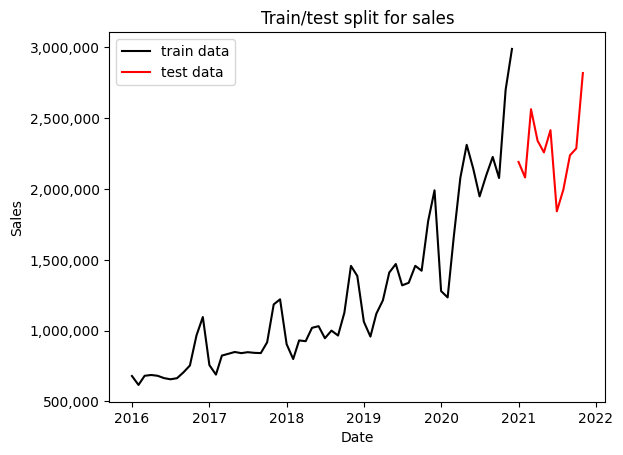

In [83]:
# Plot the train and test data in different colours to differentiate them
fig, ax = plt.subplots()
ax.plot(df_train['ds'], df_train['y'], color='black', label='train data')
ax.plot(df_test['ds'], df_test['y'], color='red', label='test data')
ax.set_ylabel('Sales')
ax.set_xlabel('Date')
ax.set_title('Train/test split for sales')
ax.legend()
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) # Edit format so sales is shown in thousands with ','

# Model

## Initialize and fit the first model

In [89]:
model = Prophet(yearly_seasonality=True)
model.fit(df_train)
clear_output()

## Fine tuning the model

### Hyperparameter tuning

In [ ]:
horizon_ = '365 days'
param_dict = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.05, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 5.0, 10.0],
}
#+++++++++++++++++++++++++++++++++++++++++++
# Generate all combinations of parameters
all_params = [dict(zip(param_dict.keys(), v)) for v in itertools.product(*param_dict.values())]
rmses = []  
# Use cross validation to evaluate all parameters
for i, params in enumerate(all_params):
    print(f'{i+1}/{len(all_params)} ==> {params}')
    model_ = Prophet(yearly_seasonality=True, **params).fit(df)  # Fit model with given params
    df_crossval = cross_validation(model_, horizon=horizon_, parallel="processes")
    df_performance = performance_metrics(df_crossval, rolling_window=1)
    rmses.append(df_performance['rmse'].values[0])

In [ ]:
print(f'Best parameters are: {all_params[np.argmin(rmses)]}')

## Make the best model using the best parameters

### Initialize and fit the model

In [84]:
model = Prophet(
    yearly_seasonality=True, 
    changepoint_prior_scale=all_params[np.argmin(rmses)]['changepoint_prior_scale'],
    seasonality_prior_scale=all_params[np.argmin(rmses)]['seasonality_prior_scale']
)
model.fit(df_train)
clear_output()

### Make a forecast of the test data

In [90]:
forecast = model.predict(df_test)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

           ds    yhat  yhat_lower  yhat_upper
0  2021-01-01 1876395     1596020     2161983
1  2021-02-01 1789683     1528478     2071512
2  2021-03-01 1989708     1713214     2258075
3  2021-04-01 2092648     1819476     2364076
4  2021-05-01 2196691     1927072     2484520
5  2021-06-01 2172186     1909668     2456601
6  2021-07-01 2087713     1822957     2341287
7  2021-08-01 2132208     1869696     2401087
8  2021-09-01 2182720     1917259     2457847
9  2021-10-01 2202969     1930909     2467000
10 2021-11-01 2557409     2272131     2823777


### View Accuracy of the Model with df_test

In [91]:
# calculate MAE and RMSE between expected and predicted values for december
y_true = df_test['y'].values
y_pred = forecast['yhat'].values
print(f'MAE: {mean_absolute_error(y_true, y_pred)}')
print(f"RMSE: {sqrt(mean_squared_error(y_true, y_pred))}")

MAE: 228699.89201300498
RMSE: 268906.0290898367


### Compare the Actual sales vs the predicted sales and show future forecast

In [92]:
# Make predictions of the future data
future_dates = model.make_future_dataframe(periods=36, freq='MS', include_history=False)
future_yhat = model.predict(future_dates)['yhat'].values

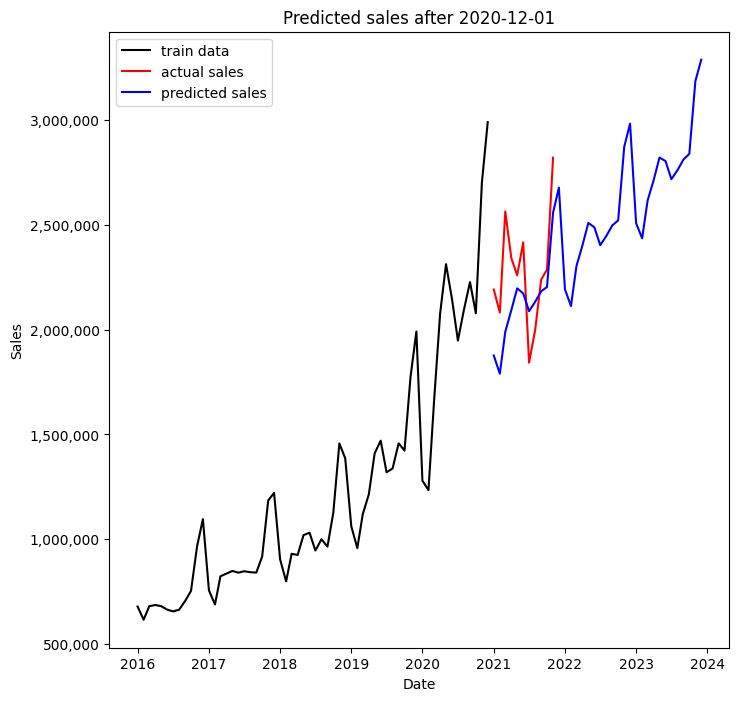

In [93]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(df_train['ds'], df_train['y'], color='black', label='train data')
ax.plot(df_test['ds'], df_test['y'], color='red', label='actual sales')
ax.plot(future_dates['ds'], future_yhat, color='blue', label='predicted sales')
ax.set_ylabel('Sales')
ax.set_xlabel('Date')
ax.set_title(f'Predicted sales after {date_boundary}')
ax.legend()
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))